In [223]:
import glob, os
from os import listdir
from os.path import isfile, join
import fnmatch
import matplotlib.pyplot as plt
from matplotlib import pylab
from pylab import *
import numpy as np
import pandas as pd
import astropy
from astropy.stats import BoxLeastSquares

import lightkurve as lk
import matplotlib.gridspec as gridspec


def ChauventsCriteron(x, y, z, mean=None, stdv=None):
    from scipy.special import erfc
    if mean is None:
        mean = y.mean()           # Mean of incoming array y
    if stdv is None:
        stdv = y.std()            # Its standard deviation
    N = len(y)                   # Lenght of incoming arrays
    criterion = 1.0/(2*N)        # Chauvenet's criterion
    d = abs(y-mean)/stdv         # Distance of a value to mean in stdv's
    d /= 2.0**0.5                # The left and right tail threshold values
    prob = erfc(d)               # Area normal dist.    
    filter = prob >= criterion   # The 'accept' filter array with booleans
    
    xf = x[filter]; yf = y[filter]; zf=z[filter]
    print ("criterion: ", criterion)
    print ("3*std:", std(y))
#     return filter                # Use boolean array outside this function
    return xf,yf,zf

Nsig=3; bin_size=5; window_size=201

In [224]:
#------------------------------Finding Downloaded TESS Data Files --------------------------------------
# path = '/Users/felizd/Desktop/Felix/TESSdata/' #location of where I put downloaded files
path = '/Users/felizd/Desktop/Felix/TESSdata/Sector01/curves/clean' #location of where I put downloaded files

data = [os.path.join(dirpath, f) # an array of path names to be looped over
    for dirpath, dirnames, files in os.walk(path) #recursively searches through directory
    for f in fnmatch.filter(files, '*.lc')] #finds every file (*) that ends with .lc

print ("number of files: ",len(data)) #number of files)

# for d in range(len(data)):
#     print ("data set #", d+1 ," : ", data[d]) #I added the d+1 because python does zero-indexing (https://en.wikipedia.org/wiki/Zero-based_numbering)
#     print ("")

number of files:  1084


In [225]:
interesting = str(183494855)

for d in range(len(data)):
    if interesting in data[d]:
        print ("file number: ", d, "file name: ", data[d])
        x= data[d] #finding where specific light curve is in our cleaned light curve folder
        
print ("x=", x)        
print ("ra: ", 18.3812, "dec: ", -76.0526) 

file number:  161 file name:  /Users/felizd/Desktop/Felix/TESSdata/Sector01/curves/clean/183494855_sector01_3_3.lc
x= /Users/felizd/Desktop/Felix/TESSdata/Sector01/curves/clean/183494855_sector01_3_3.lc
ra:  18.3812 dec:  -76.0526


not using Chauvent's criterion
6.130000000000001  days
3.6057743333335424 BJD
filenumber 1083
TIC Sector01/curves/clean/91452122_sector01_1_1


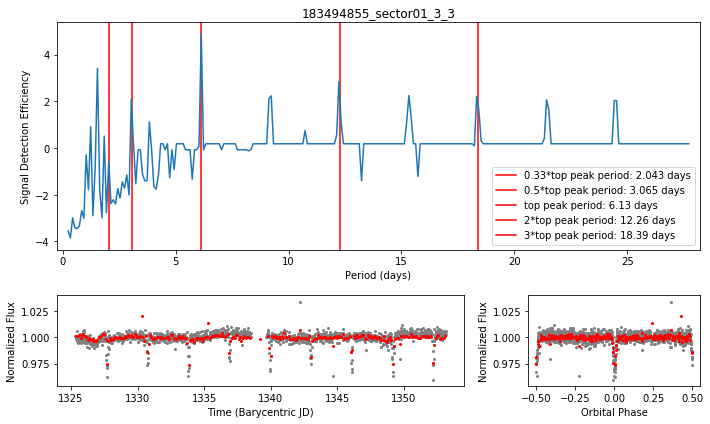

In [226]:
# Detrending and running BLS on specific light curve

Nsig=3; bin_size=5; window_size=201; spacing=0.02


time     = np.transpose(np.loadtxt(x))[0] #first  (zero indexing in python) column 
mag      = np.transpose(np.loadtxt(x))[1] #second (zero indexing in python) column 
magerror = np.transpose(np.loadtxt(x))[2] #third (zero indexing in python) column 

mask = np.where(np.isnan(mag)==False)[0] #creating array of only real numbers by setting np.isnan(mag)==False. 
time = time[mask]                        #Sometimes there are holes in data filled with NaNs
mag = mag[mask]
magerror = magerror[mask]

flux = 10.0**(mag/-2.5)/np.mean(10.0**(mag/-2.5))
fluxerror = flux*(10.0**(magerror/2.5)-1.0)

#removing outliers with Chauvenet's criterion
# print ("using Chauvent's criterion")
# t2,f2,fe2 = ChauventsCriteron(time,flux,fluxerror) #experiment with Chauvent's criterion

print ("not using Chauvent's criterion")
t2,f2,fe2 = time, flux, fluxerror                  #and without Chauvent's criterion


lc = lk.LightCurve(t2,f2,fe2)
detrended_lc = lc.flatten(window_length=window_size).bin(binsize=bin_size)


#doing BLS search:
bls = BoxLeastSquares(detrended_lc.time, detrended_lc.flux, detrended_lc.flux_err)
periods = np.arange(0.23, (max(detrended_lc.time)-min(detrended_lc.time)), 0.1)
durations = np.arange((1.0/24.0), (5.0/24.0), 0.1) #1 hr to 5 hrs
periodogram = bls.power(periods, durations,objective='snr')

#phase folding with best BLS model
index = np.argmax(periodogram.power)
best_period = periodogram.period[index]; print(best_period, " days")
best_t0 = periodogram.transit_time[index]; print(best_t0, "BJD")

detrendedphasefoldedlc = [detrended_lc.fold(period=best_period,t0=best_t0).phase,detrended_lc.fold(period=best_period,t0=best_t0).flux, detrended_lc.fold(period=best_period,t0=best_t0).flux_err]
phasefoldedlc = [lc.fold(period=best_period,t0=best_t0).phase,lc.fold(period=best_period,t0=best_t0).flux, lc.fold(period=best_period,t0=best_t0).flux_err]


SDE = (periodogram.power - np.mean(periodogram.power))/np.std(periodogram.power)
cutoff_threshold=2.0

if len(np.where(SDE>cutoff_threshold)[0])>0:
    print("filenumber",d)
    print("TIC", data[d][37:-3])

    gs1 = gridspec.GridSpec(3, 3)
    gs1.update(left=0.65, right=1.25, wspace=0.25,hspace=0.5)


    f = plt.figure(figsize=(10,6))
    ax1 = f.add_subplot(gs1[:-1, :])
    ax2 = f.add_subplot(gs1[-1, :-1])
    ax3 = f.add_subplot(gs1[-1, -1])


#     ax1.plot(periodogram.period, periodogram.power, rasterized=True) 
    ax1.plot(periodogram.period, SDE, rasterized=True)
    plt.xticks(np.arange(0.0, 31.0, 1.0))
    ax1.set_title(str(x[59:-3]))
    ax1.set_xlabel("Period (days)")
    ax1.set_xlim(np.min(periodogram.period)-0.5, np.max(periodogram.period)+0.5)
#     ax1.set_ylabel("BLS Power SNR")
    ax1.set_ylabel("Signal Detection Efficiency")
#     ax1.set_ylim(np.min(periodogram.power)-0.5, np.max(periodogram.power)+0.5)
    ax1.set_ylim(np.min(SDE)-0.5, np.max(SDE)+0.5)
    ax1.axvline(x=(1.0/3.0)*best_period,color='r',label="0.33*top peak period: "+str( np.round((1.0/3.0)*best_period,3) )+" days" ,zorder=0) 
    ax1.axvline(x=(1.0/2.0)*best_period,color='r',label="0.5*top peak period: "+str( np.round((1.0/2.0)*best_period,3) )+" days",zorder=0) 
    ax1.axvline(x=best_period,color='r',label="top peak period: "+str( np.round(best_period,3) )+" days" ,zorder=0) 
    ax1.axvline(x=(2.0)*best_period,color='r',label="2*top peak period: "+str( np.round((2.0)*best_period,3) )+" days",zorder=0) 
    ax1.axvline(x=(3.0)*best_period,color='r',label="3*top peak period: "+str( np.round((3.0)*best_period,3) )+" days",zorder=0) 
    ax1.legend(loc='best',fancybox=True)
    
    ax2.plot(detrended_lc.time,detrended_lc.flux,c='red',markersize=4,marker='.',linestyle='none',zorder=1,label='detrended: windowsize: '+str(window_size)+", binsize: "+str(bin_size)+", Nsig: "+str(Nsig))
    ax2.plot(time,flux,c='grey',marker='.',markersize=4,linestyle='none',zorder=0,label='undetrended')
#     ax2.legend(loc='upper right')
#     ax2.set_ylim(0.985,1.015)
    ax2.set_ylim(np.min(detrended_lc.flux)-spacing, np.max(detrended_lc.flux)+spacing)
    ax2.set_xlabel("Time (Barycentric JD)")
    ax2.set_ylabel("Normalized Flux") 

    ax3.plot(detrendedphasefoldedlc[0],detrendedphasefoldedlc[1],c='red',markersize=4,marker='.',linestyle='none',zorder=1,label='detrended: windowsize: '+str(window_size)+", binsize: "+str(bin_size)+", Nsig: "+str(Nsig))
    ax3.plot(phasefoldedlc[0],phasefoldedlc[1],c='grey',marker='.',markersize=4,linestyle='none',zorder=0,label='undetrended')
#     ax3.legend(loc='upper right')
    ax3.set_xlabel("Orbital Phase")
    ax3.set_ylabel("Normalized Flux") 
#     ax3.set_ylim(0.985,1.015)
    ax3.set_ylim(np.min(detrended_lc.flux)-spacing, np.max(detrended_lc.flux)+spacing)
    ax3.set_xticks(np.arange(np.min(phasefoldedlc[0]),np.max(phasefoldedlc[0])+0.25,0.25))
    gs1.tight_layout(f)

    plt.savefig("plots/"+str(x[59:-3])+".png", dpi=400, rasterized=True,bbox_inches='tight')        
    plt.show()    
    print( "") #adds space between figures


Here's a zoom in on the phase folded light curve


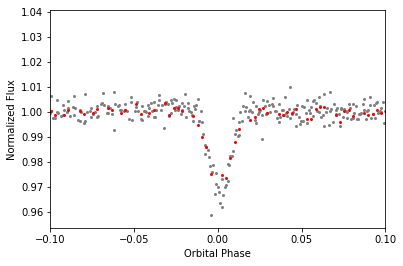

very V-shaped...


In [227]:

print("Here's a zoom in on the phase folded light curve")
plt.plot(detrendedphasefoldedlc[0],detrendedphasefoldedlc[1],c='red',markersize=4,marker='.',linestyle='none',zorder=1,label='detrended: windowsize: '+str(window_size)+", binsize: "+str(bin_size)+", Nsig: "+str(Nsig))
plt.plot(phasefoldedlc[0],phasefoldedlc[1],c='grey',marker='.',markersize=4,linestyle='none',zorder=0,label='undetrended')
plt.xlabel("Orbital Phase")
plt.ylabel("Normalized Flux") 
plt.ylim(np.min(detrended_lc.flux)-spacing, np.max(detrended_lc.flux)+spacing)
# plt.xticks(np.arange(np.min(phasefoldedlc[0]),np.max(phasefoldedlc[0])+0.1,0.1))
plt.xlim(-0.1,0.1)
plt.xticks(np.arange(-0.1,0.15,0.05))
plt.show()

print ("very V-shaped...")

experimenting with different periods like 0.25,0.5,1,2 x period to see if different depths show an eclipsing binary:
 
period:  1.5325000000000002


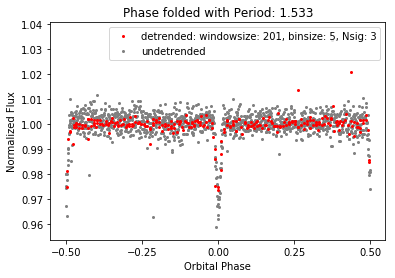


period:  3.0650000000000004


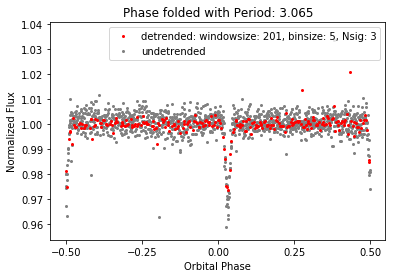


period:  6.130000000000001


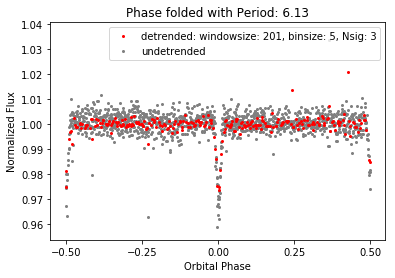


period:  12.260000000000002


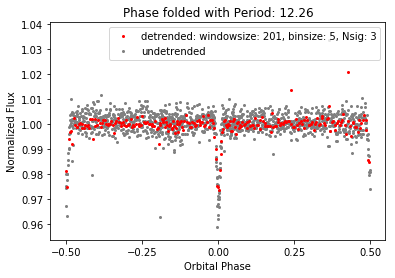


period:  24.520000000000003


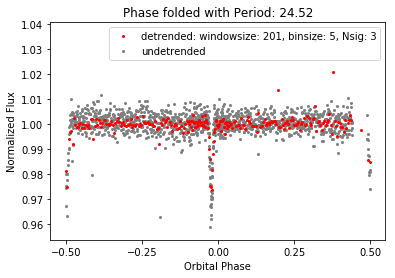

In [235]:
print ('experimenting with different periods like 0.25,0.5,1,2 x period to see if different depths show an eclipsing binary:')
print(" ")

P = 0.25*best_period
P = 0.5*best_period
P = best_period
P = 2.0*best_period
P = 4.0*best_period

P = [0.25*best_period, 0.5*best_period, best_period, 2.0*best_period,4.0*best_period]

for x in range(len(P)):
    print("period: ", P[x])
    
    detrendedphasefoldedlc = [detrended_lc.fold(period=P[x],t0=best_t0).phase,detrended_lc.fold(period=best_period,t0=best_t0).flux, detrended_lc.fold(period=best_period,t0=best_t0).flux_err]
    phasefoldedlc = [lc.fold(period=P[x],t0=best_t0).phase,lc.fold(period=best_period,t0=best_t0).flux, lc.fold(period=best_period,t0=best_t0).flux_err]


    plt.plot(detrendedphasefoldedlc[0],detrendedphasefoldedlc[1],c='red',markersize=4,marker='.',linestyle='none',zorder=1,label='detrended: windowsize: '+str(window_size)+", binsize: "+str(bin_size)+", Nsig: "+str(Nsig))
    plt.plot(phasefoldedlc[0],phasefoldedlc[1],c='grey',marker='.',markersize=4,linestyle='none',zorder=0,label='undetrended')
    plt.xlabel("Orbital Phase")
    plt.ylabel("Normalized Flux") 
    plt.ylim(np.min(detrended_lc.flux)-spacing, np.max(detrended_lc.flux)+spacing)
    plt.xticks(np.arange(np.min(phasefoldedlc[0]),np.max(phasefoldedlc[0])+0.25,0.25))
    plt.title("Phase folded with Period: "+str(np.round(P[x],3)))
    plt.legend(loc='upper right',fancybox=True)
    plt.show()
    print("")
    
    

file number:  161 file name:  /Users/felizd/Desktop/Felix/TESSdata/Sector01/curves/clean/183494855_sector01_3_3.lc
TIC ID of target star:  1834948
not using Chauvent's criterion
 
file number:  157 file name:  /Users/felizd/Desktop/Felix/TESSdata/Sector01/curves/clean/183308462_sector01_3_3.lc
not using Chauvent's criterion


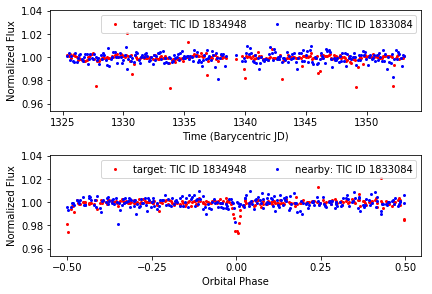

 
file number:  158 file name:  /Users/felizd/Desktop/Felix/TESSdata/Sector01/curves/clean/183492357_sector01_3_3.lc
not using Chauvent's criterion


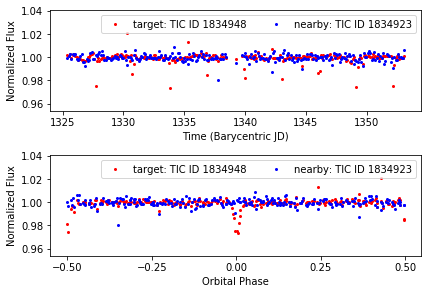

 
file number:  159 file name:  /Users/felizd/Desktop/Felix/TESSdata/Sector01/curves/clean/183492366_sector01_3_3.lc
not using Chauvent's criterion


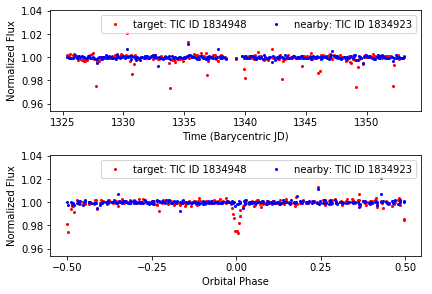

 
file number:  160 file name:  /Users/felizd/Desktop/Felix/TESSdata/Sector01/curves/clean/183494852_sector01_3_3.lc
not using Chauvent's criterion


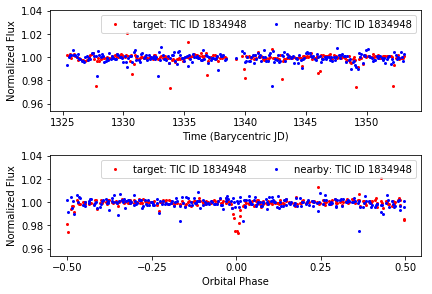

In [238]:
# compare light curves for nearby stars (close to target's RA and DEC)
# for +/- 0.1 in both RA and DEC, I found 6 stars (only checking 5, see below)

#enter TIC IDs of nearby stars:
explore_these = [183492366, 183492357, 183308462, 183494852]#, 183492956] #<---This last one isn't on Ryan's server
# this light curve for that last one doesn't seem like it's too important to the target events:
# http://astro.phy.vanderbilt.edu/~oelkerrj/tess_ffi/sector01/plots/183492956_sector01_3_3.jpg
           
target = str(183494855)

for d in range(len(data)):
    if target in data[d]:
        print ("file number: ", d, "file name: ", data[d])
        x= data[d] #finding where specific light curve is in our cleaned light curve folder    
# Here is our target star's light curve
        print ("TIC ID of target star: ", x[59:-18])
        time     = np.transpose(np.loadtxt(x))[0] #first  (zero indexing in python) column 
        mag      = np.transpose(np.loadtxt(x))[1] #second (zero indexing in python) column 
        magerror = np.transpose(np.loadtxt(x))[2] #third (zero indexing in python) column 

        mask = np.where(np.isnan(mag)==False)[0] #creating array of only real numbers by setting np.isnan(mag)==False. 
        time = time[mask]                        #Sometimes there are holes in data filled with NaNs
        mag = mag[mask]
        magerror = magerror[mask]
        flux = 10.0**(mag/-2.5)/np.mean(10.0**(mag/-2.5))
        fluxerror = flux*(10.0**(magerror/2.5)-1.0)
        #removing outliers with Chauvenet's criterion
        # print ("using Chauvent's criterion")
        # t2,f2,fe2 = ChauventsCriteron(time,flux,fluxerror) #experiment with Chauvent's criterion
        print ("not using Chauvent's criterion")
        t2,f2,fe2 = time, flux, fluxerror                  #and without Chauvent's criterion
        lc_target = lk.LightCurve(t2,f2,fe2)
        detrended_lc_target = lc_target.flatten(window_length=window_size).bin(binsize=bin_size)            
        detrendedphasefoldedlc_target = [detrended_lc_target.fold(period=best_period,t0=best_t0).phase,detrended_lc_target.fold(period=best_period,t0=best_t0).flux, detrended_lc.fold(period=best_period,t0=best_t0).flux_err]
        print(" ")
# let's do the same for the others
for d in range(len(data)):
    for y in range(len(explore_these)):
        if str(explore_these[y]) in data[d]:
            x_nearby=data[d]
            
            print ("file number: ", d, "file name: ", data[d])
            
            time     = np.transpose(np.loadtxt(x_nearby))[0] #first  (zero indexing in python) column 
            mag      = np.transpose(np.loadtxt(x_nearby))[1] #second (zero indexing in python) column 
            magerror = np.transpose(np.loadtxt(x_nearby))[2] #third (zero indexing in python) column 

            mask = np.where(np.isnan(mag)==False)[0] #creating array of only real numbers by setting np.isnan(mag)==False. 
            time = time[mask]                        #Sometimes there are holes in data filled with NaNs
            mag = mag[mask]
            magerror = magerror[mask]
            flux = 10.0**(mag/-2.5)/np.mean(10.0**(mag/-2.5))
            fluxerror = flux*(10.0**(magerror/2.5)-1.0)
            #removing outliers with Chauvenet's criterion
            # print ("using Chauvent's criterion")
            # t2,f2,fe2 = ChauventsCriteron(time,flux,fluxerror) #experiment with Chauvent's criterion
            print ("not using Chauvent's criterion")
            t2,f2,fe2 = time, flux, fluxerror                  #and without Chauvent's criterion
            lc_nearby = lk.LightCurve(t2,f2,fe2)
            detrended_lc_nearby = lc_nearby.flatten(window_length=window_size).bin(binsize=bin_size)            
            detrendedphasefoldedlc_nearby = [detrended_lc_nearby.fold(period=best_period,t0=best_t0).phase,detrended_lc_nearby.fold(period=best_period,t0=best_t0).flux, detrended_lc.fold(period=best_period,t0=best_t0).flux_err]
            
            fig ,(ax1, ax2) = plt.subplots(nrows=2, ncols=1)           
            
            ax1.plot(detrended_lc_target.time,detrended_lc_target.flux,c='red',markersize=4,marker='.',linestyle='none',zorder=1,label='target: TIC ID '+str(x[59:-18]))
            ax1.plot(detrended_lc_nearby.time,detrended_lc_nearby.flux,c='blue',markersize=4,marker='.',linestyle='none',zorder=1,label='nearby: TIC ID '+str(x_nearby[59:-18]))
            ax1.set_ylim(np.min(detrended_lc_target.flux)-spacing, np.max(detrended_lc_target.flux)+spacing)
            ax1.set_xlabel("Time (Barycentric JD)")
            ax1.set_ylabel("Normalized Flux") 
            ax1.legend(loc='upper right',fancybox=True,ncol=2)
            
            ax2.plot(detrendedphasefoldedlc_target[0],detrendedphasefoldedlc_target[1],c='red',markersize=4,marker='.',linestyle='none',zorder=1,label='target: TIC ID '+str(x[59:-18]))
            ax2.plot(detrendedphasefoldedlc_nearby[0],detrendedphasefoldedlc_nearby[1],c='blue',markersize=4,marker='.',linestyle='none',zorder=1,label='nearby: TIC ID '+str(x_nearby[59:-18]))
            ax2.set_xlabel("Orbital Phase")
            ax2.set_ylabel("Normalized Flux") 
            ax2.set_ylim(np.min(detrended_lc.flux)-spacing, np.max(detrended_lc.flux)+spacing)
            ax2.set_xticks(np.arange(np.min(phasefoldedlc[0]),np.max(phasefoldedlc[0])+0.25,0.25))
            ax2.legend(loc='upper right',fancybox=True,ncol=2)

            plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
            plt.show()
            print(" ")

In [231]:

# sig_SB = 5.67*10.0**(-5) #erg cm^-2 s^-1 K^-4

# M_sun = 1.99*10.0**33 #grams
# R_sun = 6.96*10.0**10 #cm
# T_sun = 5777 #kelvins


# L_sun= (4.0*np.pi*(R_sun**2.0))*(sig_SB*T_sun)

# def mass_estimator(T_star):
    
#     M_star = M_sun*(T_star/T_sun)**(4.0/2.5)
#     return M_star

# T_star = 3657.0 #Kelvins
# M_star = mass_estimator(T_star); print "mass of star: ", M_star/(1.99*10.0**33), "solar masses"

# def Luminosity_estimator(M_star):
#     sig_SB = 5.67*10.0**(-5.0) #erg cm^-2 s^-1 K^-4
    
#     M_sun = 1.99*10.0**33.0 #grams
#     R_sun = 6.96*10.0**10.0 #cm
#     T_sun = 5777.0 #kelvins
    
#     L_sun = (4.0*np.pi*(R_sun**2.0))*(sig_SB*T_sun)

#     L_star = L_sun* (M_star/M_sun)**3.5
    
#     return L_star


# L_star = Luminosity_estimator(M_star)
# # L_star=  (L_sun* (M_star/M_sun)**3.5)
    
# print "Luminosity of star: ", L_star/L_sun, " solar luminosity"    


# def radius_estimator(L_star,T_star):
#     R_star = ( (L_star) / ( 4.0*pi*sig_SB*(T_star**4.0) ) )**(1.0/2.0)
    
#     return R_star

# # R_star = radius_estimator(L_star,T_star)
# # print "radius of star: ", R_star#/R_sun, " solar radii"

# # R_star = (L_star/(sig_SB*4.0*np.pi*(T_star)**4.0))**(1./2.); print R_star/R_sun

# R_star = M_star/M_sun #rough approximation in solar radii
# print "radius of star: ", R_star, " solar radii"


# def radius_from_temp(T_star):
#     M_star = M_sun*(T_star/T_sun)**(4.0/2.5)
#     L_star = L_sun* (M_star/M_sun)**3.5
#     R_star = ( (L_star) / ( 4.0*pi*sig_SB*(T_star**4.0) ) )**(1.0/2.0)
    
#     return R_star

# print "radius of star: ", radius_from_temp(T_star), " solar radii"

In [232]:
# print "Period: ",p
# print "TC: ",t0, "JD"
# print "transit depth: ", BLS_output[5::18][:-1][0]
# # R_star = 0.5*6.957*10.**10. #cm
# R_e = 6.37*10.**8 #cm
# R_star = 0.10926*R_sun
# R_p = np.sqrt(BLS_output[5::18][:-1][0])*R_star; print "planet radius: ", R_p/R_e, "Earth radii"

# # T_dur = BLS_output[6::18][:-1][0]*BLS_output[5::18][:-1][0]; print T_dur*(24.), "hours"

In [233]:
# depth = 1-0.9925; print depth
# R_p = np.sqrt(depth)*R_star; print "planet radius: ", R_p/R_e, "Earth radii"